# Project: Viral Tweets

In this project, I am going to use the K-Nearest Neighbor algorithm to predict whether a tweet will go viral. Before jumping into using the classifier, let's first consider the problem we're trying to solve. Which features of a tweet are most closely linked to its popularity? Maybe the number of hashtags or the number of links in the tweet strongly influences its popularity. Maybe its virality is dependent on how many followers the person has. Maybe it's something more subtle like the specific language used in the tweets.

Let's explore these options by looking at the data we have available to us. First let's answer few questions.

* What the total number of tweets in the dataset?
* What are the columns, or features, of the dataset?
* What is the text of the first tweet in the dataset?


In [219]:
import pandas as pd

all_tweets = pd.read_json("random_tweets.json", lines=True)

print(len(all_tweets))
print(all_tweets.columns)
print(all_tweets.loc[0]['text'])

print(all_tweets.loc[0]['user']['location'])


11099
Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
RT @KWWLStormTrack7: We are more than a month into summer but the days are getting shorter. The sunrise is about 25 minutes later on July 3…
Waterloo, Iowa


# Defining Viral Tweets

A K-Nearest Neighbor classifier is a supervised machine learning algorithm, and as a result, we need to have a dataset with tagged labels. For this specific example, we need a dataset where every tweet is marked as viral or not viral. Unfortunately, this isn't a feature of our dataset &mdash; we'll need to make it ourselves.

So how do we define a viral tweet? A good place to start is to look at the number of retweets the tweet has. This can be found using the feature `"retweet_count"`. Let's say we wanted to create a column called `is_viral` that is a `1` if the tweet had more than `5` retweets and `0` otherwise. We could do that like this:

```py
all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] > 5, 1, 0)
```
Instead of using `5` as the benchmark for a viral tweet, let's use the median number of retweets. 


After finishing this project, It is worth coming back and playing with this threshold number. Classifying is easier if classes are more distinct. If I define viral as above median, I can expect lower accuracy than if I would classify viral as top 10% tweets. At the end, let's see compare the results!

In [220]:
import numpy as np

median_retweet = np.median(all_tweets['retweet_count'])
top_10 = np.quantile(all_tweets['retweet_count'], 0.9)

all_tweets['is_viral'] = np.where(all_tweets['retweet_count'] >= top_10, 1, 0)

print(median_retweet)
print(top_10)
print(all_tweets['is_viral'].value_counts())

13.0
5003.0
0    9988
1    1111
Name: is_viral, dtype: int64


# Making Features

Now that we've created a label for every tweet in our dataset, we can begin thinking about which features might determine whether a tweet is viral. We can create new columns in our dataset to represent these features. For example, let's say we think the length of a tweet might be a valuable feature. The following line creates a new column containing the length of the tweet.

```py
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
```

Setting `axis = 1` creates a new column rather than a new row.

Create a new column called `followers_count` that contains the number of followers of each user. You can find this information in `tweet['user']['followers_count']`. Do the same for `friends_count`.

For the rest of this project, we will be using these features.

* The number of words in the tweet.
* The number of hashtags in the tweet. 
* The number of links in the tweet. 
* THe number of followers.
* The number of friends.

In [221]:
all_tweets['tweet_length'] = all_tweets.apply(lambda tweet: len(tweet['text']), axis=1)
all_tweets['followers_count'] = all_tweets.apply(lambda tweet: tweet['user']['followers_count'], axis=1)
all_tweets['friends_count'] = all_tweets.apply(lambda tweet: tweet['user']['friends_count'], axis=1)
all_tweets['hashtag_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('#'), axis=1)
all_tweets['link_count'] = all_tweets.apply(lambda tweet: tweet['text'].count('http'), axis=1)


# Normalizing The Data

I've made the columns that I want to feed into my classifier. Let's get rid of all the data that is no longer relevant. Create a variable named `labels` and set it equal to the `'is_viral'` column of all_tweets.

Now create a new variable named `scaled_features`. `scaled_features` should be the result of the `scale` function with `feature` as a parameter. Also include the parameter `axis = 0`. This scales the *columns* as opposed to the rows.

The scale function will normalize the data so all of the features will vary within the same range.

Print `scaled_data[0]` to get a sense of what our data looks like.

In [222]:
from sklearn.preprocessing import scale

labels = all_tweets['is_viral']
features = all_tweets[['tweet_length', 'followers_count', 'friends_count', 'hashtag_count', 'link_count']]

scaled_features = scale(features, axis=0)
print(scaled_features[0])

[ 0.6164054  -0.02878298 -0.14483305 -0.32045057 -0.78415588]


# Creating the Training Set and Test Set

To evaluate the effectiveness of our classifier, we now split `scaled_data` and `labels` into a training set and test set using scikit-learn's `train_test_split` function. This function takes two required parameters: It takes the data, followed by the labels. Set the optional parameter `test_size` to be `0.2`. Also set the `random_state` parameter so program will randomly split the data each time in the same way. This function returns 4 items in this order:

1. The training data
2. The testing data
3. The training labels
4. The testing labels

Store the results in variables named `train_data`, `test_data`, `train_labels`, and `test_labels`.

In [223]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=1)

# Using the Classifier

Now I can finally use the K-Nearest Neighbor classifier. Let's test it using `k = 5`. Begin by creating a `KNeighborsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `5`.

Next, train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Finally, let's test the model! Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. Print the results.


In [224]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(train_data, train_labels)

classifier.score(test_data, test_labels)

0.8873873873873874

# Choosing K

We've tested our classifier with `k = 5`, but maybe there's a `k` that will work better. Let's test many different values for `k` and graph the results. 

First, create an empty list called `scores`. Next, create a for loop that has a variable `k` that begins at `1` and ends at `200`.

Inside the for loop, create a `KNeighobrsClassifier` object named `classifier` with the parameter `n_neighbors` equal to `k`.

Train `classifier` by calling the `.fit()` method with `train_data` and `train_labels` as parameters.

Next, let's test the model. Call `classifier`'s `.score()` method using `test_data` and `test_labels` as parameters. `append` the result to `scores`.

Finally, let's plot the results. Outside of the loop, use Matplotlib's `plot()` function. `plot()` takes two parameters &mdash; the data on the x-axis and the data on the y-axis. Data on the x-axis should be the values we used for `k`.

199


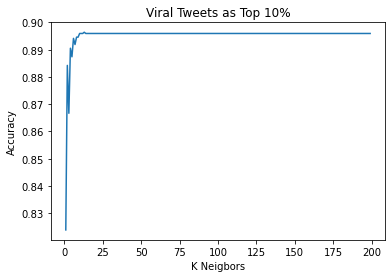

In [225]:
import matplotlib.pyplot as plt

scores = []
k_values = list(range(1, 200, 1))
print(k)
for k in range(1, 200, 1):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_data, train_labels)
    scores.append(classifier.score(test_data, test_labels))

plt.plot(range(1, 200, 1), scores)
plt.title('Viral Tweets as Top 10%')
plt.xlabel('K Neigbors')
plt.ylabel('Accuracy')
plt.savefig('Top_10.jpg')
plt.show()



# Conclusion

The classifier gets better as `k` increases, but as `k` gets too high, underfitting starts to happen. That why I should try to have lowest k value, with highest accuracy score.

By using the features `tweet_length`, `followers_count`,`friends_count`, `hashtag_count` and `link_count`, I was able to get up to around 60% accuracy classyfing viral tweets as these above median. That is better than random, but still not exceptional. Although if I would like to classify more distinct, let's say top 10% as viral, results get even better, which makes sense. It is easier to classify them as they are more different. In this case Accuracy is almost 90%. That's very good result!